In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import keras
from keras.layers import Conv2D, Flatten, Dense
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append('..')
import condense
import tensorflow as tf
tf.get_logger().setLevel(0)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Dataset
ds = tfds.load('mnist', split='train', shuffle_files=True, as_supervised=True)
ds.repeat().shuffle(2000)
ds.prefetch(tf.data.experimental.AUTOTUNE)

def generator(batch_size):
    while True:
        X, y = next(tfds.as_numpy(ds.batch(batch_size)))
        yield X.reshape(batch_size, 28, 28, 1), keras.utils.to_categorical(y, 10)
        
gen = generator(400)

# Convolutional Model

Loss of unpruned model: 0.021149247884750366


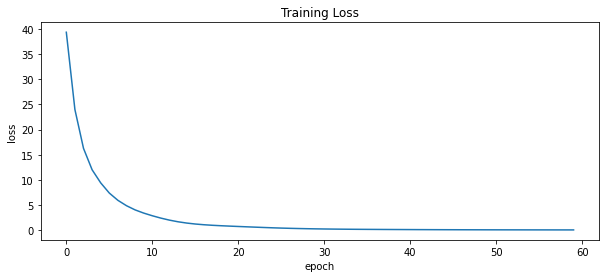

In [2]:
model = keras.models.Sequential(layers=[
    Conv2D(input_shape=(28,28,1), filters=2, kernel_size=(4,4), activation='relu'),
    Conv2D(filters=2, kernel_size=(4,4), activation='relu'),
    Conv2D(filters=2, kernel_size=(2,2), activation='relu'),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax'),
])

model.compile('adam', 'categorical_crossentropy')
training_hist = model.fit(gen, epochs=60, steps_per_epoch=1, verbose=0)

model.save('mnist.h5')

plt.figure(figsize=(10,4))
plt.plot(training_hist.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
_ = plt.title('Training Loss')
unpruned_loss = model.evaluate(gen, steps=100, verbose=0)
print(f'Loss of unpruned model: {unpruned_loss}')

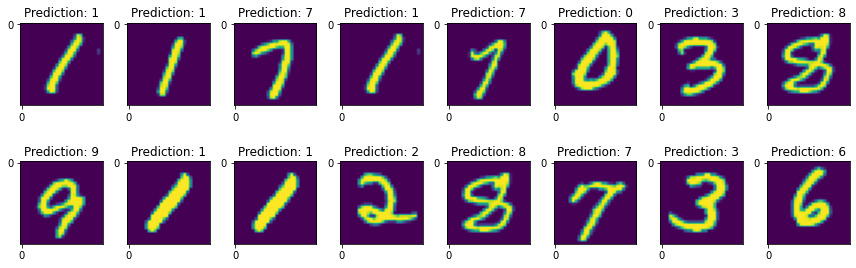

In [3]:
def prediction_plot(model):
    plt.figure(figsize=(12, 4))
    for i in range(1,2*8+1):
        plt.subplot(2,8, i)
        X, y = next(tfds.as_numpy(ds.take(2000).shuffle(20)))
        X = X.reshape(1,28,28,1)
        plt.imshow(X[0])
        plt.title(f'Prediction: {int(np.argmax(model.predict(X)[0]))}')
        plt.xticks([0])
        plt.yticks([0])
    plt.tight_layout()
    
prediction_plot(model)

# One-Shot Network Pruning
with target sparsity of 40%.

Loss increased from 0.021149247884750366 to 0.6860489249229431.
Layer 0 Sparsity:  0.375
Layer 1 Sparsity:  0.390625
Layer 2 Sparsity:  0.375
Layer 4 Sparsity:  0.39999645691609975
Layer 5 Sparsity:  0.4


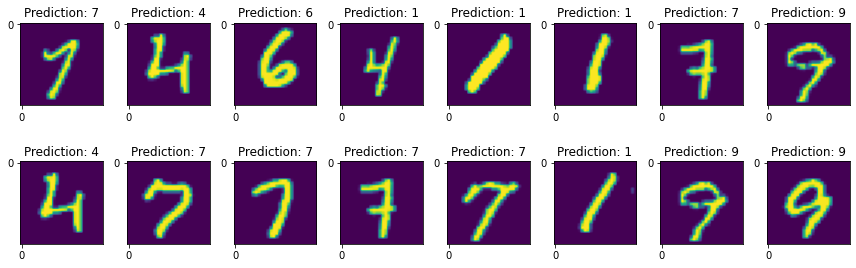

In [8]:
model = keras.models.load_model('mnist.h5')
pruned = condense.keras.wrap_model(model, condense.optimizer.sparsity_functions.Constant(0.4))
pruned.compile(keras.optimizers.Adam(learning_rate=0.0), 'categorical_crossentropy')
pruned.fit(gen, epochs=1, steps_per_epoch=1, callbacks=[condense.keras.PruningCallback()], verbose=0)
pruned_loss = pruned.evaluate(gen, steps=10, verbose=0)
print(f'Loss increased from {unpruned_loss} to {pruned_loss}.')
prediction_plot(pruned)
for i, layer in enumerate(pruned.layers):
    if isinstance(layer, condense.keras.PruningWrapper):
        print(f'Layer {i} Sparsity: ', condense.utils.layer_utils.calc_layer_sparsity(layer.layer.kernel.numpy()))

## Pruning over a range of sparsity targets

Text(0, 0.5, 'Loss')

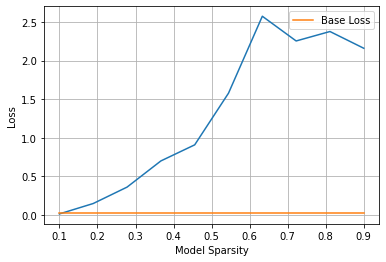

In [5]:
model = keras.models.load_model('mnist.h5')

def prune_constant(acc, epochs=1):
    model = keras.models.load_model('mnist.h5')
    p = condense.keras.wrap_model(model, condense.optimizer.sparsity_functions.Constant(acc))
    p.compile(keras.optimizers.Adam(learning_rate=0.001), 'categorical_crossentropy')
    p.fit(gen, epochs=epochs, steps_per_epoch=1, callbacks=[condense.keras.PruningCallback()], verbose=0)
    return p.evaluate(gen, steps=10, verbose=0)

acc_ranges = np.linspace(0.1, 0.9, 10)
plt.plot(acc_ranges, [prune_constant(acc) for acc in acc_ranges])
plt.plot(acc_ranges, len(acc_ranges)*[unpruned_loss], label='Base Loss')
plt.legend()
plt.grid()
plt.xlabel('Model Sparsity')
plt.ylabel('Loss')

# Linear Sparsity Function

Text(0, 0.5, 'Loss')

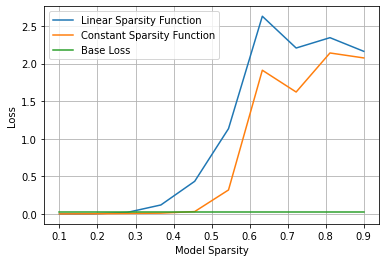

In [7]:
def prune_linear(acc, epochs=1):
    model = keras.models.load_model('mnist.h5')
    p = condense.keras.wrap_model(model, condense.optimizer.sparsity_functions.Linear(acc))
    p.compile(keras.optimizers.Adam(learning_rate=0.001), 'categorical_crossentropy')
    p.fit(gen, epochs=epochs, steps_per_epoch=1, callbacks=[condense.keras.PruningCallback()], verbose=0)
    return p.evaluate(gen, steps=10, verbose=0)

acc_ranges = np.linspace(0.1, 0.9, 10)
plt.plot(acc_ranges, [prune_linear(acc, 10) for acc in acc_ranges], label='Linear Sparsity Function')
plt.plot(acc_ranges, [prune_constant(acc, 10) for acc in acc_ranges], label='Constant Sparsity Function')
plt.plot(acc_ranges, len(acc_ranges)*[unpruned_loss], label='Base Loss')
plt.legend()
plt.grid()
plt.xlabel('Model Sparsity')
plt.ylabel('Loss')